In [1]:
#pip install recommenders


In [99]:
#print(tf.executing_eagerly())  # should be True now

True


In [199]:
import kagglehub 
import pandas as pd 
import numpy as np 
import os 
import seaborn as sns
import random 
import matplotlib.pyplot as plt
import tensorflow as tf 
from transformers import DistilBertTokenizer, TFDistilBertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout,Attention,Multiply
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Model
from math import sqrt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam
from time import time
#from recommenders.evaluation.python_evaluation import (
    #map, ndcg_at_k, precision_at_k, recall_at_k
#)
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm 
from collections import defaultdict,Counter

#### STEP 1 : LOADING THE DATASET FROM KAGGLE 

In [ ]:
devices = tf.config.get_visible_devices()
print(devices)

In [ ]:
#strategy = tf.distribute.MirroredStrategy()

In [ ]:
#path = kagglehub.dataset_download("samlearner/letterboxd-movie-ratings-data")

#print("Path to dataset files:", path)

In [ ]:
#movie_data_filename = 'movie_data.csv'
#ratings_filename = 'ratings_export.csv'
#users_filename = 'users_export.csv'
#movie_data_path = os.path.join(path,movie_data_filename)
#ratings_path = os.path.join(path,ratings_filename)
#users_path = os.path.join(path,users_filename)

In [ ]:
# movie_data_df = pd.read_csv(movie_data_path,engine='python')
# ratings_df = pd.read_csv(ratings_path,engine='python')
# users_df = pd.read_csv(users_path,engine = 'python')

In [210]:
movie_data_df = pd.read_parquet('/kaggle/input/parquet-dataset/movie_data.parquet',engine='pyarrow')
ratings_df = pd.read_parquet('/kaggle/input/parquet-dataset/ratings_data.parquet',engine='pyarrow')
users_df = pd.read_parquet('/kaggle/input/parquet-dataset/users_dt.parquet',engine='pyarrow')

In [ ]:
print(users_df.head())


# this dataframe won't be used, as we don't want the models predictions to depend on the users data. 

unneccessary columns need to be removed - image url, imdb id, imdb, link (perhaps needed to enhance model with imdb data ? ), tmbd id, link, (download that dataset and enhance with it ? )production countries, 

In [202]:
print(movie_data_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285963 entries, 0 to 285962
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   _id                   285963 non-null  object 
 1   genres                274986 non-null  object 
 2   image_url             264521 non-null  object 
 3   imdb_id               243898 non-null  object 
 4   imdb_link             243914 non-null  object 
 5   movie_id              285616 non-null  object 
 6   movie_title           283453 non-null  object 
 7   original_language     274986 non-null  object 
 8   overview              261362 non-null  object 
 9   popularity            274872 non-null  float64
 10  production_countries  274854 non-null  object 
 11  release_date          270954 non-null  object 
 12  runtime               269943 non-null  float64
 13  spoken_languages      274758 non-null  object 
 14  tmdb_id               279803 non-null  float64
 15  

# we can check if adding additional information from this dataframe to the model improves its performance (genre of the movie, overview? tokenized, year_released)

In [ ]:
print(ratings_df.head())

In [ ]:
print(ratings_df.info())

In [ ]:
for col in movie_data_df.select_dtypes(include='object'):
    print(f"{col}: {movie_data_df[col].nunique()} unique values")


In [ ]:
#movie_data_df.to_parquet('movie_data.parquet', engine='pyarrow')
#ratings_df.to_parquet('ratings_data.parquet', engine = 'pyarrow')
#users_df.to_parquet('users_dt.parquet',engine = 'pyarrow')
# Load from Parquet file



#### STEP 2: EXPLORATORY DATA ANALYSIS 

In [213]:
movie_data_df = movie_data_df.dropna(subset=['overview'])

In [214]:
movie_data_df['overview_length'] = movie_data_df['overview'].apply(len)

avg_length = movie_data_df['overview_length'].mean()
min_length = movie_data_df['overview_length'].min()
max_length = movie_data_df['overview_length'].max()
movie_data_df.drop(['overview_length'],axis = 1)
print(f"Average Overview Length: {avg_length:.2f}")
print(f"Minimum Overview Length: {min_length}")
print(f"Maximum Overview Length: {max_length}")


Average Overview Length: 283.60
Minimum Overview Length: 1
Maximum Overview Length: 1000


#### STEP 3: DEFINING THE TASK, EVALUATION METRICS, CONSTRUCTING MODEL 

In [ ]:
#tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
#model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')


In [128]:
#ncf_model.load_weights('ncf_model.weights.h5')
# model can be saved locally after training so it doesn't have to be redone again 

In [ ]:
#texts = movie_data_df['overview'].fillna('').tolist()
#inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="tf", max_length=128)
#with strategy.scope():
    #outputs = model(**inputs).last_hidden_state.mean(dim=1)

# Get embeddings (use outputs.last_hidden_state or outputs.pooler_output)
#movie_df['embedding'] = embeddings.numpy().tolist()

In [215]:
ratings_df.dropna(subset=['user_id', 'movie_id', 'rating_val'], inplace=True)
movie_data_df.dropna(subset=['genres'], inplace=True)

In [ ]:
ratings_df.head()

# non integer frames must be mapped to a unique numeric value - movie id and user id in this case

In [218]:
user_mapping = {user: idx for idx, user in enumerate(ratings_df['user_id'].unique())}
item_mapping = {item: idx for idx, item in enumerate(ratings_df['movie_id'].unique())}
all_genres = set(genre for genres in movie_data_df['genres'] for genre in genres)
genre_mapping = {genre: idx for idx, genre in enumerate(sorted(all_genres))}
movie_data_df['genre_mapped'] = movie_data_df['genres'].apply(
    lambda genres: [genre_mapping[genre] for genre in genres if genre in genre_mapping]
)
print(genre_mapping)

{' ': 0, '"': 1, ',': 2, '.': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, 'A': 14, 'C': 15, 'D': 16, 'F': 17, 'H': 18, 'M': 19, 'R': 20, 'S': 21, 'T': 22, 'V': 23, 'W': 24, '[': 25, ']': 26, 'a': 27, 'c': 28, 'd': 29, 'e': 30, 'h': 31, 'i': 32, 'l': 33, 'm': 34, 'n': 35, 'o': 36, 'r': 37, 's': 38, 't': 39, 'u': 40, 'v': 41, 'y': 42}


In [ ]:
sample_items = list(user_mapping.items())[:10]
print(sample_items)

In [ ]:
# merged_df = ratings_df.merge(
#     movie_data_df[['movie_id', 'release_date','popularity_scaled']],  
#     on='movie_id', 
#     how='inner'  # 'inner' if only want ratings for movies that exist in movie_data_df
# )

In [205]:
ratings_df['user_id'] = ratings_df['user_id'].map(user_mapping)
ratings_df['movie_id'] = ratings_df['movie_id'].map(item_mapping)
ratings_df.head()

,_id,movie_id,rating_val,user_id
0,5fc57c5d6758f6963451a07f,0,7,0
1,5fc57c5d6758f6963451a063,1,7,0
2,5fc57c5d6758f6963451a0ef,2,7,0
3,5fc57c5d6758f6963451a060,3,4,0
4,5fc57c5c6758f69634519398,4,5,0


In [219]:
print(movie_data_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 261362 entries, 0 to 285956
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   _id                   261362 non-null  object 
 1   genres                261362 non-null  object 
 2   image_url             244826 non-null  object 
 3   imdb_id               228067 non-null  object 
 4   imdb_link             228083 non-null  object 
 5   movie_id              261246 non-null  float64
 6   movie_title           261362 non-null  object 
 7   original_language     261362 non-null  object 
 8   overview              261362 non-null  object 
 9   popularity            261248 non-null  float64
 10  production_countries  261230 non-null  object 
 11  release_date          257747 non-null  object 
 12  runtime               257853 non-null  float64
 13  spoken_languages      261134 non-null  object 
 14  tmdb_id               261134 non-null  float64
 15  tmdb_

In [220]:
movie_data_df['movie_id'] = movie_data_df['movie_id'].map(item_mapping)
movie_data_df['genre'] = movie_data_df['genres'].map(genre_mapping)
movie_data_df.head()

,_id,genres,image_url,imdb_id,imdb_link,movie_id,movie_title,original_language,overview,popularity,...,runtime,spoken_languages,tmdb_id,tmdb_link,vote_average,vote_count,year_released,overview_length,genre,genre_mapped
0,5fc85f606758f69634496fd3,"[""Music"",""Animation""]",film-poster/4/6/4/4/4/0/464440-football-freaks...,None,None,NaN,Football Freaks,en,"Football crazy, football mad. Don’t watch this...",0.600,...,0.0,[],535272.0,https://www.themoviedb.org/movie/535272/,0.0,0.0,1971.0,826,NaN,"[25, 1, 19, 40, 38, 32, 28, 1, 2, 1, 14, 35, 3..."
1,5fc85ff26758f696344ace0c,[],film-poster/2/4/5/5/0/0/245500-aftermath-0-230...,tt0586129,http://www.imdb.com/title/tt0586129/maindetails,NaN,Aftermath,en,Aftermath was the pilot for an unsold TV serie...,0.600,...,22.0,[],318331.0,https://www.themoviedb.org/movie/318331/,8.0,1.0,1960.0,273,NaN,"[25, 26]"
2,5fc85f606758f69634496fcd,"[""Drama""]",film-poster/9/3/3/1/8/93318-where-chimneys-are...,tt0045731,http://www.imdb.com/title/tt0045731/maindetails,NaN,Where Chimneys Are Seen,ja,Gosho’s most celebrated film both in Japan and...,1.568,...,108.0,"[""日本語""]",117779.0,https://www.themoviedb.org/movie/117779/,6.6,10.0,1953.0,370,NaN,"[25, 1, 16, 37, 27, 34, 27, 1, 26]"
3,5fc85f606758f69634496fd1,"[""Drama""]",None,tt0187327,http://www.imdb.com/title/tt0187327/maindetails,NaN,The Musician's Daughter,en,Carl Wagner's good wife was dying. His heart b...,0.600,...,15.0,[],560377.0,https://www.themoviedb.org/movie/560377/,0.0,0.0,1911.0,871,NaN,"[25, 1, 16, 37, 27, 34, 27, 1, 26]"
4,5fc85f606758f69634496fd4,"[""Documentary""]",film-poster/4/5/4/6/0/3/454603-50-years-of-fab...,tt4769914,http://www.imdb.com/title/tt4769914/maindetails,NaN,50 Years of Fabulous,en,50 Years of Fabulous recounts the rich history...,0.600,...,75.0,[],525187.0,https://www.themoviedb.org/movie/525187/,0.0,0.0,2018.0,920,NaN,"[25, 1, 16, 36, 28, 40, 34, 30, 35, 39, 27, 37..."


In [152]:
ratings_df = ratings_df.drop(['_id'],axis = 1)
ratings_df.head()

,movie_id,rating_val,user_id
0,0,7,0
1,1,7,0
2,2,7,0
3,3,4,0
4,4,5,0


In [11]:
train, val = train_test_split(ratings_df, test_size=0.2, random_state=42)
train, test = train_test_split(train, test_size = 0.2, random_state = 42)

In [132]:
n_users = len(user_mapping)
n_items = len(item_mapping)
print(f'No. users : {n_users}, no. items : {n_items}')
#print(user_mapping)

No. users : 7477, no. items : 286070


# easiest to construct model using functional API (multiple input network). 3 dense layers of sizes 64,32,16 respectively follow the embedding layers

In [14]:
embedding_dim = 32  # Latent factor size
mlp_layer_sizes = [64, 32, 16]  # Fully connected layers

# 1d input for user and item 
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

# Embedding layers
user_embedding = Embedding(n_users, embedding_dim, name='user_embedding')(user_input)
item_embedding = Embedding(n_items, embedding_dim, name='item_embedding')(item_input)

# Flatten embeddings
user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)

gmf_vec = Multiply()([user_vec,item_vec])
# Concatenate embeddings
concat_vec = Concatenate()([user_vec, item_vec])
# MLP layers
mlp = concat_vec
for size in mlp_layer_sizes:
    mlp = Dense(size, activation='relu')(mlp)
    mlp = Dropout(0.2)(mlp)

pre_output_concatenate = Concatenate()([gmf_vec,mlp])
# Output layer (e.g., single rating prediction)
output = Dense(1, activation='linear', name='output')(pre_output_concatenate)

# Build and compile the model
ncf_model = Model(inputs=[user_input, item_input], outputs=output)
ncf_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

ncf_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 32)          │        239,264 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_embedding            │ (None, 1, 32)          │      9,154,272 │ item_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 32)             │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 32)             │              0 │ item_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64)             │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          4,160 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          2,080 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 16)             │            528 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 32)             │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 16)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 48)             │              0 │ multiply[0][0],        │
│ (Concatenate)             │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │             49 │ concatenate_1[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,400,353 (35.86 MB)

 Trainable params: 9,400,353 (35.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#tf.config.get_visible_devices()

In [133]:
train_dict = defaultdict(set)

# Assuming your train DataFrame has columns 'user_id' and 'movie_id':
for user, item in zip(train['userID'], train['itemID']):
    train_dict[user].add(item)
    

In [ ]:
x_train = [train['user_id'].values, train['movie_id'].values]
y_train = train['rating_val'].values
x_val = [val['user_id'].values, val['movie_id'].values]
y_val = val['rating_val'].values
x_test = [test['user_id'].values, test['movie_id'].values]
y_test = test['rating_val'].values
print(y_test.shape)
print(y_val.shape)
print(type(x_train))
print(type(x_test))
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)
# Train the model
history = ncf_model.fit(
    x=x_train,
    y=y_train,
    batch_size=256,
    epochs=5,
    validation_data=(x_val, y_val),
    verbose=1,
    callbacks = [early_stop_callback]
)
#uncomment above to train model again, weights can be loaded aswell

In [ ]:
#ncf_model.load_weights('ncf_model.weights.h5')

In [ ]:
ncf_model.save_weights('ncf_model.weights.h5')

In [ ]:
loss, mae = ncf_model.evaluate(x_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# RMSE
predictions = ncf_model.predict(x_test)
rmse = sqrt(np.mean((predictions.flatten() - y_test) ** 2))
print(f"Test RMSE: {rmse:.4f}")

In [43]:
user_id = 'jay'  # Replace with a valid user_id
user_idx = user_mapping.get(user_id)
print(user_idx)
# Predict ratings for all items
all_items = np.arange(n_items)
user_tensor = np.array([user_idx] * n_items)
predicted_ratings = ncf_model.predict([user_tensor, all_items])

# Get top 10 recommendations
top_items = np.argsort(predicted_ratings.flatten())[::-1][:10]
recommended_movie_ids = [list(item_mapping.keys())[list(item_mapping.values()).index(idx)] for idx in top_items]
print(f"Recommended movies for user {user_id}: {recommended_movie_ids}")

7
8940/8940 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
Recommended movies for user jay: ['the-mistress-2020', 'where-the-wild-things-are-and-other-maurice-sendak-stories-2001', 'sky-hook', 'like-shooting-stars', 'tallahassee', 'tooth-fairy-2001', 'aahar', 'ever-after-high-dragon-games', 'suttu-pidikka-utharavu', 'in-the-line-of-duty-7-sea-wolves']


In [ ]:
test = test.rename(columns={'rating_val': 'prediction'})

In [ ]:
print(test)

In [ ]:
# all_user_ids = list(user_mapping.keys())       # e.g. original user IDs
# all_user_idxs = list(user_mapping.values())    # integer indices
# BATCH_SIZE = 512
# all_items = np.arange(n_items)

# predictions_list = []
# for i in range(0, len(all_user_idxs), BATCH_SIZE):
#     # Take a chunk of users
#     user_idx_batch = all_user_idxs[i : i + BATCH_SIZE]
#     user_id_batch = all_user_ids[i : i + BATCH_SIZE]

#     # Repeat items for each user in the batch
#     # shape: (#users_in_batch * n_items,)
#     tile_users = np.repeat(user_idx_batch, n_items)
#     tile_items = np.tile(all_items, len(user_idx_batch))

#     # Model predict on that entire chunk
#     batch_preds = ncf_model.predict([tile_users, tile_items])  

#     # Now we map predictions back to (user, item) pairs
#     # We'll build a DataFrame
#     df_chunk = pd.DataFrame({
#         "userID": np.repeat(user_id_batch, n_items),
#         "itemID": tile_items,
#         "prediction": batch_preds
#     })
#     predictions_list.append(df_chunk)

# predictions_df = pd.concat(predictions_list, ignore_index=True)
### 1 HOUR 45 MINS FOR ENTIRE DATASET 

In [ ]:
# print(predictions_df)

In [32]:
test.rename(
    columns={
        "movie_id": "itemID",
        "user_id": "userID",
        "rating_val": "rating"  
    },
    inplace=True,
)

train.rename(
    columns={
        "movie_id": "itemID",  
        "user_id": "userID"
    },
    inplace=True,
)

In [ ]:
# # Evaluate predictions
# #eval_map = map(test, predictions_df, col_prediction='prediction', k=TOP_K)
# eval_ndcg = ndcg_at_k(test, predictions_df, col_prediction='prediction', k=TOP_K)
# print("reaches this")
# eval_precision = precision_at_k(test, predictions_df, col_prediction='prediction', k=TOP_K)
# print("reaches this")
# eval_recall = recall_at_k(test, predictions_df, col_prediction='prediction', k=TOP_K)
# print("reaches this")
# print(
#     #f"MAP:\t{eval_map:.6f}",
#     f"NDCG:\t{eval_ndcg:.6f}",
#     f"Precision@K:\t{eval_precision:.6f}",
#     f"Recall@K:\t{eval_recall:.6f}",
#     sep='\n'
# )

## COMPLEXITY OF PREDICTING FOR ALL USERS AND ITEMS IS (no_users * no_items) -> VERY LARGE. 
Use negative sampling - take 1 item user interacted with, and 50 or 100 items the user did NOT interact (did not rate). 

# with manual testing for different users, the model basically outputs the highest rated shows and movies that the user has not rated. how to improve on that ? -> tokenization of movie descriptions into the model, another pipeline with the genre. 

In [ ]:
print(train)

In [ ]:
print(test)

In [134]:
all_items_set = set(train['itemID'].unique()) | set(test['itemID'].unique())

In [ ]:
# Parameters
k = 10
hits = []
ndcgs = []
precisions = []
recalls = []
all_true_labels = []
all_pred_scores = []
recommended_items = []

unique_user_ids = test['userID'].unique()

# Evaluation Loop
for user_id in tqdm(unique_user_ids[:100], desc="Processing users"):
    # Fetch the test items for the user
    test_items = test.loc[test['userID'] == user_id, 'itemID'].values
    pos_items = set(test_items)  
    limited_pos_items = list(pos_items)[:3] # take only 3, on processor only takes too slow for all 
    # Build negative set (exclude train_dict[user_id] + the positive items)
    user_train_items = train_dict[user_id] | set(limited_pos_items)
    possible_negatives = list(all_items_set - user_train_items)

    # Iterate over each positive item
    for pos_item in limited_pos_items:
        # Sample 99 negatives for the current positive item
        neg_sample = random.sample(list(all_items_set - train_dict[user_id] - {pos_item}), 99)
        
        # Combine into a batch
        item_batch = [pos_item] + neg_sample
        user_batch = [user_id] * len(item_batch)
        
        # Get predictions
        scores = ncf_model.predict([np.array(user_batch), np.array(item_batch)])
        scores = np.squeeze(scores)
        
        # Binary labels: 1 for positive item, 0 for negatives
        labels = np.array([1] + [0]*99)
        all_true_labels.extend(labels)
        all_pred_scores.extend(scores)
        
        # Sort items by score in descending order
        sorted_indices = np.argsort(scores)[::-1]
        sorted_labels = labels[sorted_indices]
        sorted_items = np.array(item_batch)[sorted_indices]
        
        # Collect recommended items for distribution analysis
        top_k_items = sorted_items[:k]
        recommended_items.extend(top_k_items.tolist())
        
        # Calculate Hit@K, if positive item in these, its a hit
        if 1 in sorted_labels[:k]:
            hits.append(1)
        else:
            hits.append(0)
        
        # Calculate NDCG@K
        rank = np.where(sorted_labels[:k] == 1)[0]
        if len(rank) > 0:
            ndcgs.append(1 / np.log2(rank[0] + 2))  
        else:
            ndcgs.append(0)
        
        # Calculate Precision@K
        precision = np.sum(sorted_labels[:k]) / k
        precisions.append(precision)
        
        # Calculate Recall@K
        recall = np.sum(sorted_labels[:k]) / len(limited_pos_items)
        recalls.append(recall)

# Calculate Final Metrics
hit_rate = np.mean(hits)
ndcg = np.mean(ndcgs)
precision_at_k = np.mean(precisions)
recall_at_k = np.mean(recalls)
auc = roc_auc_score(all_true_labels, all_pred_scores)



In [ ]:
hit_rate = np.mean(hits)
ndcg = np.mean(ndcgs)
precision_at_k = np.mean(precisions)
recall_at_k = np.mean(recalls)
auc = roc_auc_score(all_true_labels, all_pred_scores)

print(f"Hit Rate@{k}: {hit_rate:.4f}")
print(f"NDCG@{k}: {ndcg:.4f}")
print(f"Precision@{k}: {precision_at_k:.4f}")
print(f"Recall@{k}: {recall_at_k:.4f}")
print(f"ROC AUC: {auc:.4f}")

## Interpretation :
- 45% of users get something relevant to them recommended 
- ndcg : 29% to an ideal ranking system (higher relevance items raise it )
- precision : 1 of 22 items is relevant to user (too low!)
- recall : 15% of a users relevant items are 

In [ ]:
fpr, tpr, thresholds = roc_curve(all_true_labels, all_pred_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Interesting to check the distribution of the recomended movies for each user. 

In [ ]:
item_counts = Counter(recommended_items)
item_counts_df = pd.DataFrame.from_dict(item_counts, orient='index', columns=['count'])
item_counts_df.reset_index(inplace=True)
item_counts_df.rename(columns={'index': 'itemID'}, inplace=True)
item_counts_df.sort_values(by='count', ascending=False, inplace=True)

In [ ]:
plt.figure(figsize=(12, 8))
sns.histplot(item_counts_df['count'], bins=50, kde=True)
plt.xlabel('Number of Recommendations')
plt.ylabel('Frequency')
plt.title('Distribution of Recommended Movies')
plt.show()

In [ ]:
## heavy bias to the highest rated movies (can also be seen by the manual checks for each user)

In [ ]:
# Hit@10: 0.4800
#NDCG@10: 0.3067

In [ ]:
# The relevant items is in 48 percent of reccomended lists to the user, ndcg of 30 percent means we are 30 percent to an ideal ranking 

## This is a good baseline, however it can be improved, in multiple ways

## 1. Train GMF and MLP models separately, then combine into new model, fine-tune that one to see if improvements (paper suggests this technique gives better results)

In [16]:
user_gmf_embedding = Embedding(n_users, embedding_dim, name='user_gmf_embedding')(user_input)
item_gmf_embedding = Embedding(n_items, embedding_dim, name='item_gmf_embedding')(item_input)

# Flatten embeddings
user_gmf_vec = Flatten()(user_gmf_embedding)
item_gmf_vec = Flatten()(item_gmf_embedding)

# Element-wise product of user and item embeddings
gmf_vec = Multiply()([user_gmf_vec, item_gmf_vec])

# Output layer
gmf_output = Dense(1, activation='linear', name='gmf_output')(gmf_vec)

# Build and compile GMF model
gmf_model = Model(inputs=[user_input, item_input], outputs=gmf_output)
gmf_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

gmf_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_gmf_embedding        │ (None, 1, 32)          │        239,264 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_gmf_embedding        │ (None, 1, 32)          │      9,154,272 │ item_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 32)             │              0 │ user_gmf_embedding[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 32)             │              0 │ item_gmf_embedding[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 32)             │              0 │ flatten_2[0][0],       │
│                           │                        │                │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gmf_output (Dense)        │ (None, 1)              │             33 │ multiply_1[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,393,569 (35.83 MB)

 Trainable params: 9,393,569 (35.83 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# MLP model - neural network 
user_mlp_embedding = Embedding(n_users, embedding_dim, name='user_mlp_embedding')(user_input)
item_mlp_embedding = Embedding(n_items, embedding_dim, name='item_mlp_embedding')(item_input)

# Flatten embeddings
user_mlp_vec = Flatten()(user_mlp_embedding)
item_mlp_vec = Flatten()(item_mlp_embedding)

# Concatenate embeddings
mlp_vec = Concatenate()([user_mlp_vec, item_mlp_vec])

# Fully connected layers
mlp = mlp_vec
for size in mlp_layer_sizes:
    mlp = Dense(size, activation='relu')(mlp)
    mlp = Dropout(0.2)(mlp)

# Output layer
mlp_output = Dense(1, activation='linear', name='mlp_output')(mlp)

# Build and compile MLP model
mlp_model = Model(inputs=[user_input, item_input], outputs=mlp_output)
mlp_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [19]:
x_train = [train['user_id'].values, train['movie_id'].values]
y_train = train['rating_val'].values
x_val = [val['user_id'].values, val['movie_id'].values]
y_val = val['rating_val'].values
x_test = [test['user_id'].values, test['movie_id'].values]
y_test = test['rating_val'].values
# Train GMF model
gmf_history = gmf_model.fit(
    x=x_train,
    y=y_train,
    batch_size=256,
    epochs=5,
    validation_data=(x_val, y_val),
    verbose=1
)

# Train MLP model
mlp_history = mlp_model.fit(
    x=x_train,
    y=y_train,
    batch_size=256,
    epochs=5,
    validation_data=(x_val, y_val),
    verbose=1
)

Epoch 1/5
27696/27696 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - loss: 10.8881 - mae: 2.3665 - val_loss: 2.1791 - val_mae: 1.1306
Epoch 2/5
27696/27696 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step - loss: 2.0482 - mae: 1.0930 - val_loss: 2.0524 - val_mae: 1.0942
Epoch 3/5
27696/27696 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step - loss: 1.8282 - mae: 1.0244 - val_loss: 2.0112 - val_mae: 1.0811
Epoch 4/5
27696/27696 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step - loss: 1.6774 - mae: 0.9755 - val_loss: 2.0085 - val_mae: 1.0791
Epoch 5/5
27696/27696 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - loss: 1.5635 - mae: 0.9361 - val_loss: 2.0243 - val_mae: 1.0830
Epoch 1/5
27696/27696 ━━━━━━━━━━━━━━━━━━━━ 108s 4ms/step - loss: 3.8239 - mae: 1.4811 - val_loss: 2.2565 - val_mae: 1.1532
Epoch 2/5
27696/27696 ━━━━━━━━━━━━━━━━━━━━ 102s 4ms/step - loss: 2.2250 - mae: 1.1447 - val_loss: 2.1412 - val_mae: 1.1199
Epoch 3/5
27696/27696 ━━━━━━━━━━━━━━━━━━━━ 102s 4ms/step - loss: 2.1106 - mae: 1.1116 - val_loss: 2.1220 - val_mae: 1.1149
Epoch 4/5
27696/2769

In [21]:
#gmf_model.save_weights('ncf_model.weights.h5')
gmf_model.save_weights('gmf_model.weights.h5')
mlp_model.save_weights('mlp_model.weights.h5')

In [25]:
alpha = 0.5  

# Weighted combination of GMF and MLP vectors
gmf_weighted = Multiply()([gmf_vec, Lambda(lambda x: x * alpha)(gmf_vec)])
mlp_weighted = Multiply()([mlp, Lambda(lambda x: x * (1 - alpha))(mlp)])

combined = Concatenate()([gmf_weighted, mlp_weighted])

final_output = Dense(1, activation='linear', name='final_output')(combined)

# Build the final NCF model
ncf_combined_model = Model(inputs=[user_input, item_input], outputs=final_output)
ncf_combined_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

ncf_combined_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_mlp_embedding        │ (None, 1, 32)          │        239,264 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_mlp_embedding        │ (None, 1, 32)          │      9,154,272 │ item_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 32)             │              0 │ user_mlp_embedding[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 32)             │              0 │ item_mlp_embedding[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 64)             │              0 │ flatten_4[0][0],       │
│ (Concatenate)             │                        │                │ flatten_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │          4,160 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │          2,080 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_gmf_embedding        │ (None, 1, 32)          │        239,264 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_gmf_embedding        │ (None, 1, 32)          │      9,154,272 │ item_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 32)             │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 32)             │              0 │ user_gmf_embedding[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 32)             │              0 │ item_gmf_embedding[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 16)             │            528 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 32)             │              0 │ flatten_2[0][0],       │
│                      

 Total params: 18,793,889 (71.69 MB)

 Trainable params: 18,793,889 (71.69 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
alphas = [0.25, 0.5, 0.75]
# trained on all 3, balanced one gave best results 

In [ ]:
# Parameters
k = 10
hits = []
ndcgs = []
precisions = []
recalls = []
all_true_labels = []
all_pred_scores = []
recommended_items = []

unique_user_ids = test['userID'].unique()

# Evaluation Loop
for user_id in tqdm(unique_user_ids[:100], desc="Processing users"):
    # Fetch the test items for the user
    test_items = test.loc[test['userID'] == user_id, 'itemID'].values
    pos_items = set(test_items)  
    limited_pos_items = list(pos_items)[:3] # take only 3, on processor only takes too slow for all 
    # Build negative set (exclude train_dict[user_id] + the positive items)
    user_train_items = train_dict[user_id] | set(limited_pos_items)
    possible_negatives = list(all_items_set - user_train_items)

    # Iterate over each positive item
    for pos_item in limited_pos_items:
        # Sample 99 negatives for the current positive item
        neg_sample = random.sample(list(all_items_set - train_dict[user_id] - {pos_item}), 99)
        
        # Combine into a batch
        item_batch = [pos_item] + neg_sample
        user_batch = [user_id] * len(item_batch)
        
        # Get predictions
        scores = ncf_combined_model.predict([np.array(user_batch), np.array(item_batch)])
        scores = np.squeeze(scores)
        
        # Binary labels: 1 for positive item, 0 for negatives
        labels = np.array([1] + [0]*99)
        all_true_labels.extend(labels)
        all_pred_scores.extend(scores)
        
        # Sort items by score in descending order
        sorted_indices = np.argsort(scores)[::-1]
        sorted_labels = labels[sorted_indices]
        sorted_items = np.array(item_batch)[sorted_indices]
        
        # Collect recommended items for distribution analysis
        top_k_items = sorted_items[:k]
        recommended_items.extend(top_k_items.tolist())
        
        # Calculate Hit@K, if positive item in these, its a hit
        if 1 in sorted_labels[:k]:
            hits.append(1)
        else:
            hits.append(0)
        
        # Calculate NDCG@K
        rank = np.where(sorted_labels[:k] == 1)[0]
        if len(rank) > 0:
            ndcgs.append(1 / np.log2(rank[0] + 2))  
        else:
            ndcgs.append(0)
        
        # Calculate Precision@K
        precision = np.sum(sorted_labels[:k]) / k
        precisions.append(precision)
        
        # Calculate Recall@K
        recall = np.sum(sorted_labels[:k]) / len(limited_pos_items)
        recalls.append(recall)

# Calculate Final Metrics
hit_rate = np.mean(hits)
ndcg = np.mean(ndcgs)
precision_at_k = np.mean(precisions)
recall_at_k = np.mean(recalls)
auc = roc_auc_score(all_true_labels, all_pred_scores)


In [39]:
hit_rate = np.mean(hits)
ndcg = np.mean(ndcgs)
precision_at_k = np.mean(precisions)
recall_at_k = np.mean(recalls)
auc = roc_auc_score(all_true_labels, all_pred_scores)

print(f"Hit Rate@{k}: {hit_rate:.4f}")
print(f"NDCG@{k}: {ndcg:.4f}")
print(f"Precision@{k}: {precision_at_k:.4f}")
print(f"Recall@{k}: {recall_at_k:.4f}")
print(f"ROC AUC: {auc:.4f}")

Hit Rate@10: 0.6733
NDCG@10: 0.4019
Precision@10: 0.0673
Recall@10: 0.2244
ROC AUC: 0.8771


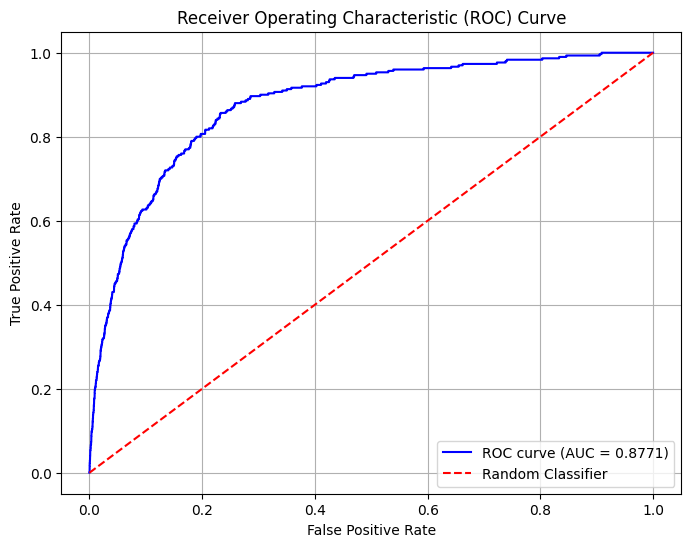

In [96]:
fpr, tpr, thresholds = roc_curve(all_true_labels, all_pred_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('good_curve.png')
plt.show()

Hit Rate@10: 0.6733
NDCG@10: 0.4019
Precision@10: 0.0673
Recall@10: 0.2244
ROC AUC: 0.8771

In [ ]:
#ncf_combined_model.load_weights('ncf_combined_model.weights.h5')

In [41]:
ncf_combined_model.save_weights('ncf_combined_model.weights.h5')

In [29]:
print(movie_data_df.head())

                        _id                 genres  \
0  5fc85f606758f69634496fd3  ["Music","Animation"]   
1  5fc85ff26758f696344ace0c                     []   
2  5fc85f606758f69634496fcd              ["Drama"]   
3  5fc85f606758f69634496fd1              ["Drama"]   
4  5fc85f606758f69634496fd4        ["Documentary"]   

                                           image_url    imdb_id  \
0  film-poster/4/6/4/4/4/0/464440-football-freaks...       None   
1  film-poster/2/4/5/5/0/0/245500-aftermath-0-230...  tt0586129   
2  film-poster/9/3/3/1/8/93318-where-chimneys-are...  tt0045731   
3                                               None  tt0187327   
4  film-poster/4/5/4/6/0/3/454603-50-years-of-fab...  tt4769914   

                                         imdb_link                 movie_id  \
0                                             None          football-freaks   
1  http://www.imdb.com/title/tt0586129/maindetails           aftermath-1960   
2  http://www.imdb.com/title/tt0045

In [30]:
print(merged_df.head())

                        _id    movie_id  rating_val         user_id  \
0  5fc57c5d6758f6963451a07f  feast-2014           7      deathproof   
1  5fc57ca06758f69634538bad  feast-2014          10  ingridgoeswest   
2  5fc57cbd6758f696345475a3  feast-2014           8           dirkh   
3  5fc57ce06758f6963455400b  feast-2014          10   childrenofmen   
4  5fc57cf36758f69634558b0e  feast-2014           8      suspirliam   

  release_date  
0   2014-10-25  
1   2014-10-25  
2   2014-10-25  
3   2014-10-25  
4   2014-10-25  


## 2. Improve on the suggested architecture :
- use other information in the dataset: ex. genre, popularity, overview of the movies 
- add layers to the model - batch normalization, dropout, change loss function, 
- evaluate the model with tenfold cross validation 
- ensemble with tokenization of movie overview 
- add precision@k,AUC,recall@k,mean reciprocal rank (MRR)
- graph embeddings ? 
- l1-l2 regularization
- autoencoder of user and item 


In [153]:
movie_data_df = movie_data_df.dropna(subset=['genres', 'popularity','overview','release_date'])

In [154]:
print(ratings_df)

          movie_id  rating_val  user_id
0                0           7        0
1                1           7        0
2                2           7        0
3                3           4        0
4                4           5        0
...            ...         ...      ...
11078162      4395           6     7452
11078163      9265           7     7452
11078164     17847           6     7452
11078165      4107           7     7452
11078166    282607           5     7452

[11078161 rows x 3 columns]


In [170]:
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(movie_data_df['genres'])
genre_labels = mlb.classes_  # Get genre labels from the MultiLabelBinarizer
genres_encoded_df = pd.DataFrame(genres_encoded, columns=genre_labels, index=movie_data_df.index)
# Normalize popularity
scaler = MinMaxScaler()
movie_data_df['popularity_scaled'] = scaler.fit_transform(movie_data_df[['popularity']])
movie_data_df = pd.concat([movie_data_df, genres_encoded_df], axis=1)
# Vectorize the overview (example using TextVectorization)
vectorizer = TextVectorization(output_sequence_length=1000)  # Adjust length as needed
vectorizer.adapt(movie_data_df['overview'])
overview_vectors = vectorizer(movie_data_df['overview'])


In [171]:
print(movie_data_df.head())

                        _id                 genres  \
0  5fc85f606758f69634496fd3  ["Music","Animation"]   
1  5fc85ff26758f696344ace0c                     []   
2  5fc85f606758f69634496fcd              ["Drama"]   
3  5fc85f606758f69634496fd1              ["Drama"]   
4  5fc85f606758f69634496fd4        ["Documentary"]   

                                           image_url    imdb_id  \
0  film-poster/4/6/4/4/4/0/464440-football-freaks...       None   
1  film-poster/2/4/5/5/0/0/245500-aftermath-0-230...  tt0586129   
2  film-poster/9/3/3/1/8/93318-where-chimneys-are...  tt0045731   
3                                               None  tt0187327   
4  film-poster/4/5/4/6/0/3/454603-50-years-of-fab...  tt4769914   

                                         imdb_link  movie_id  \
0                                             None    179439   
1  http://www.imdb.com/title/tt0586129/maindetails    110176   
2  http://www.imdb.com/title/tt0045731/maindetails     59111   
3  http://www.im

In [157]:
print(ratings_df.head())

   movie_id  rating_val  user_id
0         0           7        0
1         1           7        0
2         2           7        0
3         3           4        0
4         4           5        0


In [146]:
ratings_df['movie_id'] = ratings_df['movie_id'].astype(int)
movie_data_df['movie_id'] = movie_data_df['movie_id'].astype(int)
movie_data_df = movie_data_df.dropna(subset=['movie_id'])
ratings_df = ratings_df.dropna(subset=['movie_id'])

In [179]:
print(list(mlb.classes_))

[' ', '"', ',', 'A', 'C', 'D', 'F', 'H', 'M', 'R', 'S', 'T', 'V', 'W', '[', ']', 'a', 'c', 'd', 'e', 'h', 'i', 'l', 'm', 'n', 'o', 'r', 's', 't', 'u', 'v', 'y']


In [177]:
print(genre_labels)

[' ' '"' ',' 'A' 'C' 'D' 'F' 'H' 'M' 'R' 'S' 'T' 'V' 'W' '[' ']' 'a' 'c'
 'd' 'e' 'h' 'i' 'l' 'm' 'n' 'o' 'r' 's' 't' 'u' 'v' 'y']


In [180]:
genre_columns = [col for col in movie_data_df.columns if col in genre_labels]

In [181]:
merged_df_large = ratings_df.merge(
    movie_data_df[['movie_id','popularity_scaled'] + genre_columns],  
    on='movie_id', 
    how='inner'  # 'inner' if only want ratings for movies that exist in movie_data_df
)

In [182]:
print(merged_df_large.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10879249 entries, 0 to 10879248
Data columns (total 36 columns):
 #   Column             Dtype  
---  ------             -----  
 0   movie_id           int64  
 1   rating_val         int64  
 2   user_id            int64  
 3   popularity_scaled  float64
 4                      int64  
 5   "                  int64  
 6   ,                  int64  
 7   A                  int64  
 8   C                  int64  
 9   D                  int64  
 10  F                  int64  
 11  H                  int64  
 12  M                  int64  
 13  R                  int64  
 14  S                  int64  
 15  T                  int64  
 16  V                  int64  
 17  W                  int64  
 18  [                  int64  
 19  ]                  int64  
 20  a                  int64  
 21  c                  int64  
 22  d                  int64  
 23  e                  int64  
 24  h                  int64  
 25  i               

In [183]:
train1, val1 = train_test_split(merged_df_large, test_size=0.2, random_state=42)
train1, test1 = train_test_split(train1, test_size = 0.2, random_state = 42)

In [ ]:
# train now needs to have + popularity scaled from movie data df merged,

In [184]:
print(val1.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2175850 entries, 3468264 to 6129587
Data columns (total 36 columns):
 #   Column             Dtype  
---  ------             -----  
 0   movie_id           int64  
 1   rating_val         int64  
 2   user_id            int64  
 3   popularity_scaled  float64
 4                      int64  
 5   "                  int64  
 6   ,                  int64  
 7   A                  int64  
 8   C                  int64  
 9   D                  int64  
 10  F                  int64  
 11  H                  int64  
 12  M                  int64  
 13  R                  int64  
 14  S                  int64  
 15  T                  int64  
 16  V                  int64  
 17  W                  int64  
 18  [                  int64  
 19  ]                  int64  
 20  a                  int64  
 21  c                  int64  
 22  d                  int64  
 23  e                  int64  
 24  h                  int64  
 25  i                

In [119]:
overview_vectors_train = tf.gather(overview_vectors, train1.index.to_numpy())
overview_vectors_val = tf.gather(overview_vectors, val1.index.to_numpy())

# Convert to float32
overview_vectors_train = tf.cast(overview_vectors_train, tf.float32)
overview_vectors_val = tf.cast(overview_vectors_val, tf.float32)

In [165]:
embedding_dim = 32  # Latent factor size
mlp_layer_sizes = [64, 32, 16]  # Fully connected layers
overview_dim = overview_vectors.shape[1]  # Assuming `overview_vectors` has shape (num_samples, vector_dim)

# Inputs
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')
genres_input = Input(shape=(genres_encoded.shape[1],), name='genres_input')  # One-hot encoded genres
popularity_input = Input(shape=(1,), name='popularity_input')  # Single scalar value
overview_input = Input(shape=(overview_dim,), name='overview_input')  # Vectorized overview

# Embedding layers for user and item
user_embedding = Embedding(n_users, embedding_dim, name='user_embedding')(user_input)
item_embedding = Embedding(n_items, embedding_dim, name='item_embedding')(item_input)

# Flatten embeddings
user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)

# GMF layer (element-wise multiplication of embeddings)
gmf_vec = Multiply()([user_vec, item_vec])

# Concatenate all features
all_features = Concatenate()([user_vec, item_vec, genres_input, popularity_input, overview_input])

# MLP layers
mlp = all_features
for size in mlp_layer_sizes:
    mlp = Dense(size, activation='relu')(mlp)
    mlp = Dropout(0.2)(mlp)

# Combine GMF and MLP
pre_output_concatenate = Concatenate()([gmf_vec, mlp])

# Output layer (e.g., single rating prediction)
output = Dense(1, activation='linear', name='output')(pre_output_concatenate)

# Build and compile the model
big_model = Model(inputs=[user_input, item_input, genres_input, popularity_input, overview_input], outputs=output)
big_model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])

# Model summary
big_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 32)          │        239,264 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_embedding            │ (None, 1, 32)          │      9,154,240 │ item_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_16 (Flatten)      │ (None, 32)             │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_17 (Flatten)      │ (None, 32)             │              0 │ item_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ genres_input (InputLayer) │ (None, 32)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ popularity_input          │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ overview_input            │ (None, 1000)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_15            │ (None, 1097)           │              0 │ flatten_16[0][0],      │
│ (Concatenate)             │                        │                │ flatten_17[0][0],      │
│                           │                        │                │ genres_input[0][0],    │
│                           │                        │                │ popularity_input[0][0… │
│                           │                        │                │ overview_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 64)             │         70,272 │ concatenate_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 64)             │              0 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 32)             │          2,080 │ dropout_21[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 32)             │              0 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 16)             │            528 │ dropout_22[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_10 (Multiply

 Total params: 9,466,433 (36.11 MB)

 Trainable params: 9,466,433 (36.11 MB)

 Non-trainable params: 0 (0.00 B)

In [174]:
print(train1.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6962719 entries, 7213783 to 4034565
Data columns (total 4 columns):
 #   Column             Dtype  
---  ------             -----  
 0   movie_id           int64  
 1   rating_val         int64  
 2   user_id            int64  
 3   popularity_scaled  float64
dtypes: float64(1), int64(3)
memory usage: 265.6 MB
None


In [173]:
x_train1 = [
    train1['user_id'].values, 
    train1['movie_id'].values, 
    train1[genre_labels].values,  # Use genre columns directly, 
    train1['popularity_scaled'].values, 
    overview_vectors_train
]
y_train1 = train1['rating_val'].values

x_val1 = [
    val1['user_id'].values, 
    val1['movie_id'].values, 
    genres_encoded[val1.index], 
    val1[genre_labels].values, 
    overview_vectors_val
]
y_val1 = val1['rating_val'].values


KeyError: 'None of [Index([\' \', \'"\', \',\', \'A\', \'C\', \'D\', \'F\', \'H\', \'M\', \'R\', \'S\', \'T\', \'V\', \'W\',\n       \'[\', \']\', \'a\', \'c\', \'d\', \'e\', \'h\', \'i\', \'l\', \'m\', \'n\', \'o\', \'r\', \'s\',\n       \'t\', \'u\', \'v\', \'y\'],\n      dtype=\'object\')] are in the [columns]'

In [95]:
#big_model.load_weights('ncf_combined_model.weights.h5')
# try without loading the pretrained first 

In [122]:
for i, x in enumerate(x_train1):
    print(f"x_train[{i}] shape: {x.shape}, dtype: {x.dtype}")

for i, x in enumerate(x_val1):
    print(f"x_val[{i}] shape: {x.shape}, dtype: {x.dtype}")

x_train[0] shape: (135482,), dtype: int64
x_train[1] shape: (135482,), dtype: object
x_train[2] shape: (135482, 32), dtype: int64
x_train[3] shape: (135482,), dtype: float64
x_train[4] shape: (135482, 1000), dtype: <dtype: 'float32'>
x_val[0] shape: (42339,), dtype: int64
x_val[1] shape: (42339,), dtype: object
x_val[2] shape: (42339, 32), dtype: int64
x_val[3] shape: (42339,), dtype: float64
x_val[4] shape: (42339, 1000), dtype: <dtype: 'float32'>


In [112]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7090026 entries, 9502416 to 10236209
Data columns (total 3 columns):
 #   Column      Dtype
---  ------      -----
 0   itemID      int64
 1   rating_val  int64
 2   userID      int64
dtypes: int64(3)
memory usage: 216.4 MB
None


In [123]:
print(train1.info())

<class 'pandas.core.frame.DataFrame'>
Index: 135482 entries, 124462 to 48561
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   movie_id           135482 non-null  object 
 1   rating_val         135482 non-null  int64  
 2   user_id            135482 non-null  int64  
 3   release_date       135482 non-null  object 
 4   popularity_scaled  135482 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 6.2+ MB
None


In [124]:
print(type(overview_vectors))
print(overview_vectors.dtype)
print(overview_vectors.shape)  # Should be (num_samples, vector_dim)
print(overview_vectors_train.shape)  # Should be (train_samples, vector_dim)
print(overview_vectors_val.shape)    # Should be (val_samples, vector_dim)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'int64'>
(257747, 1000)
(135482, 1000)
(42339, 1000)


In [125]:
history = big_model.fit(
    x=x_train1,
    y=y_train1,
    validation_data=(x_val1, y_val1),
    batch_size=128,  # Adjust batch size based on memory and dataset size
    epochs=10,  # Number of epochs
    verbose=1  # Print training progress
)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node data_1 defined at (most recent call last):
<stack traces unavailable>
Detected at node data_1 defined at (most recent call last):
<stack traces unavailable>
Detected unsupported operations when trying to compile graph __inference_one_step_on_data_2640491[] on XLA_GPU_JIT: _Arg (No registered '_Arg' OpKernel for XLA_GPU_JIT devices compatible with node {{node data_1}}
	 (OpKernel was found, but attributes didn't match) Requested Attributes: T=DT_STRING, _output_shapes=[[128]], _user_specified_name="data", index=1){{node data_1}}
The op is created at: 
File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "<ipython-input-125-ce9bd21f52c9>", line 1, in <cell line: 1>
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator
File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/polymorphism/function_type.py", line 356, in placeholder_arguments
File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 250, in placeholder_value
File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 251, in <listcomp>
File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 250, in placeholder_value
File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 251, in <listcomp>
	tf2xla conversion failed while converting __inference_one_step_on_data_2640491[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_2640574]